In [7]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [8]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

In [9]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)


## Asimov Cases

In [10]:
true_energy = dataset_load.exposure.geom.axes[0].center.value

e_reco = 0.1
print(e_reco)

0.1


In [11]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_N = sys_d_cor.create_dataset_N()
dataset = sys_d_cor.create_dataset()
dataset_input = sys_d_cor.create_dataset()


with dataset_N.models.parameters.restore_status(): 
    dataset_N.models.parameters['e_reco'].value = e_reco
    dataset.counts = dataset_N.npred()
    dataset_N.counts = dataset_N.npred()


sigma_e = 0.1

penalising_covmatrix = [[1/sigma_e**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
#dataset_N.models.parameters['e_reco'].value = e_reco



Text(0.5, 1.0, 'Residual Standard Dataset')

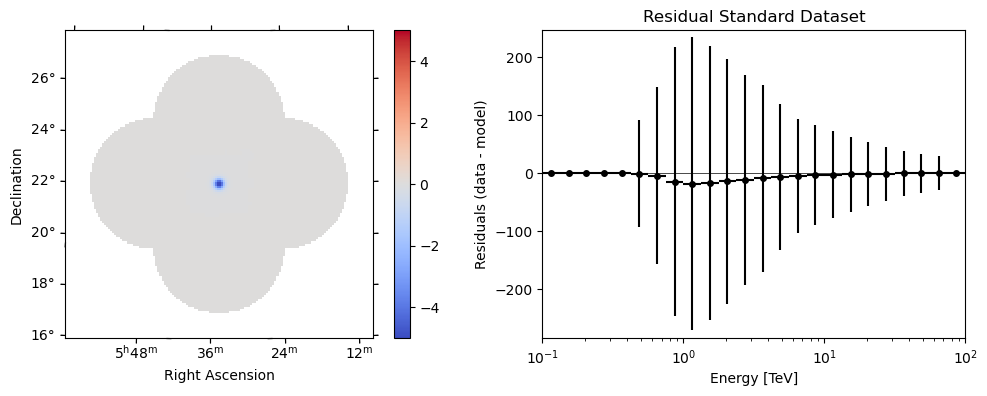

In [12]:
dataset.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")
#fig.savefig("plots/2-Residual_st.pdf")

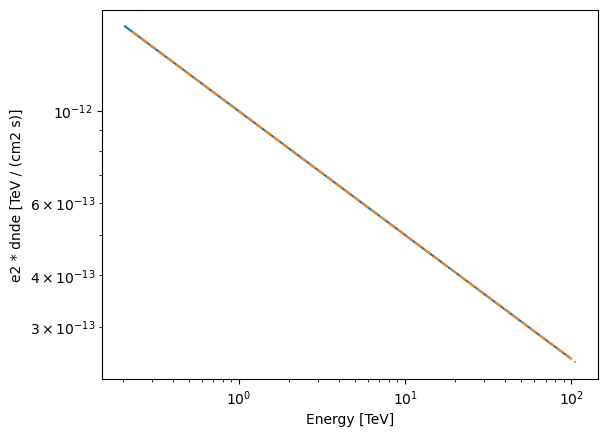

In [13]:
energy_bounds= (0.2, 100) *u.TeV

#ax = dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, 
#                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

ax = dataset.models[0].spectral_model.plot(energy_bounds, energy_power = 2, )
with dataset_N.models.parameters.restore_status(): 
    dataset_N.models.parameters['e_reco'].value = e_reco
    dataset_N.models[0].spectral_model.plot(energy_bounds, linestyle= '--', ax = ax, energy_power = 2, )

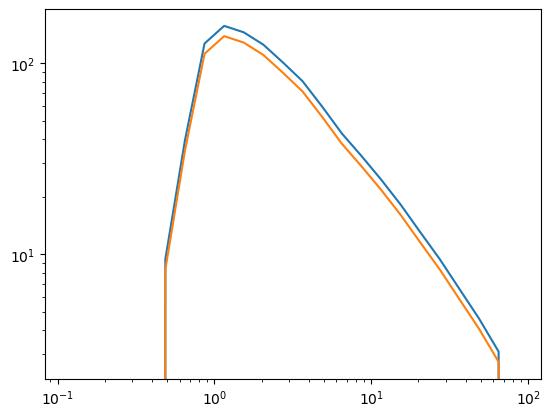

In [14]:
true_energy = dataset_N.exposure.geom.axes[0].center.value

energy_bounds= (0.2, 100) *u.TeV

def sum_e(data):
    return data.sum(axis=2).sum(axis=1)

pred_shift = sum_e(dataset.npred_signal().data)

with dataset_N.models.parameters.restore_status(): 
    dataset_N.models.parameters['e_reco'].value = e_reco
    pred_asimov = sum_e(dataset_N.npred_signal().data)

plt.plot(true_energy, pred_shift)
plt.plot(true_energy, pred_asimov)
plt.loglog()
plt.yscale('log')

CPU times: user 4.15 s, sys: 39.8 ms, total: 4.19 s
Wall time: 4.2 s


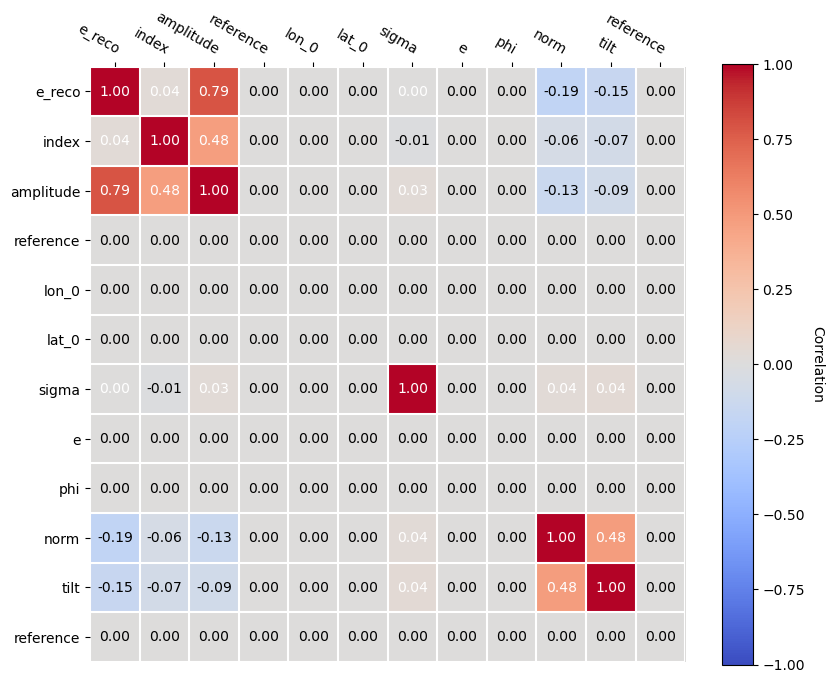

In [15]:
%%time
fit = Fit()
result = fit.run(dataset)
dataset_N.models.parameters['e_reco'].frozen = False
result = fit.run(dataset_N)


dataset_N.models.covariance = fit.covariance(dataset_N).matrix
dataset_N.models.covariance.plot_correlation()

dataset_N.models[0].spectral_model.model.covariance = dataset_N.models.covariance.get_subcovariance(dataset_N.models[0].spectral_model.model.parameters)
dataset_N.models[0].spectral_model.model.covariance = dataset_N.models.covariance.get_subcovariance(dataset_N.models[0].spectral_model.model.parameters)

dataset_N.models.parameters['e_reco'].frozen = True


In [16]:
dataset.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3012e+00,,6.931e-02,nan,nan,False,False,False,
spectral,amplitude,8.8478e-13,cm-2 s-1 TeV-1,8.912e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,8.3631e+01,deg,0.000e+00,nan,nan,True,False,False,
spatial,lat_0,2.2018e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,False,
spatial,sigma,2.0107e-02,deg,1.142e-02,0.000e+00,nan,False,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,False,
spectral,norm,9.9995e-01,,2.018e-03,nan,nan,False,True,False,


In [17]:
dataset_N.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,e_reco,2.4105e-03,,9.382e-02,nan,nan,True,False,True,
spectral,index,2.3006e+00,,6.989e-02,nan,nan,False,False,False,
spectral,amplitude,8.8687e-13,cm-2 s-1 TeV-1,1.484e-13,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,8.3631e+01,deg,0.000e+00,nan,nan,True,False,False,
spatial,lat_0,2.2018e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,False,
spatial,sigma,2.0227e-02,deg,1.152e-02,0.000e+00,nan,False,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,False,


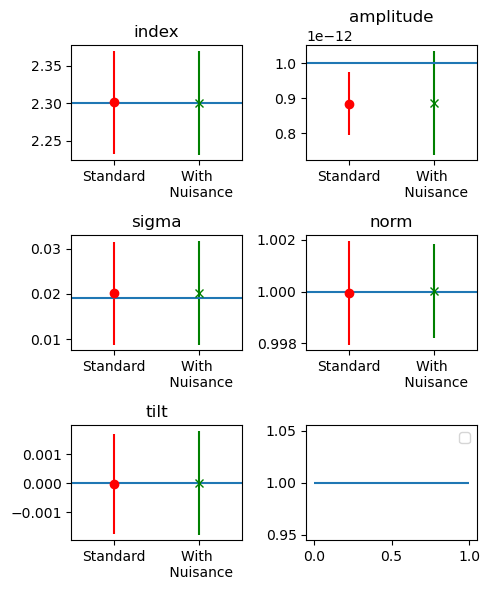

In [18]:
fig,ax = plt.subplots(3,2, figsize = (5,6))
ax = ax.flatten()
par_N = dataset_N.models.parameters.free_parameters
par_N = Parameters([p for p in par_N if p.name!='e_reco'])

par = dataset.models.parameters.free_parameters

inputs = dataset_input.models.parameters.free_parameters.value
inputs = np.append(inputs, [1.0, 1.0, 1.0])
names = []
for i in range(len( par)):
    p_N = par_N[i].copy()
    p = par[i].copy()
    ax[i].errorbar(0, p.value ,yerr = p.error , fmt = 'o', color = 'red',)
    ax[i].errorbar(1, p_N.value ,yerr = p_N.error, fmt =  'x', color = 'green',)
    ax[i].plot([-0.5, 1.5], [inputs[i]]*2)
    ax[i].set_xticks(np.arange(2), ['Standard', 'With \n Nuisance']);    
    ax[i].set_xlim(-0.5,1.5)
    ax[i].set_title(p.name)
xlim = plt.xlim()
plt.hlines(1, xlim[0], xlim[1] )    

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
fig.savefig(f"plots/2-Best_Fit_{e_reco}.png")

index
amplitude
index
amplitude
index
amplitude
index
amplitude


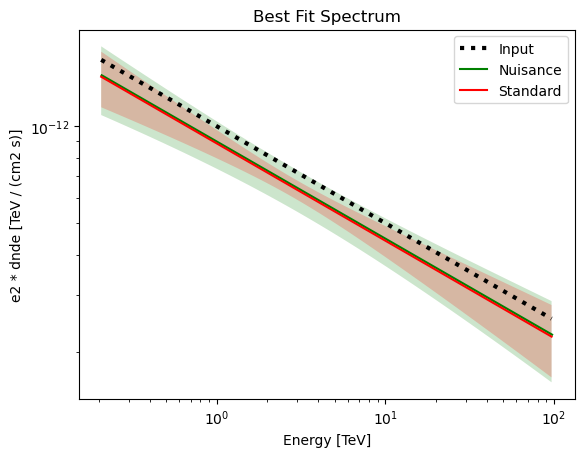

In [19]:


fig,ax = plt.subplots()
dataset_input.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')




dataset_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Nuisance", color = 'green')
dataset_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green')
dataset.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                    label = "Standard", color = 'red')
dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                           facecolor='red')
plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
fig.savefig("plots/2_spectrum.pdf")